# Titre projet

## Introduction

## Methodology

- on a des datas (120 variables) marcos de 1960 à 2025 - on séparer le train et le test set à partir de 2016 - on normalise en prenant les moments tu train sur le test et le train - on fait PCA en se basant sur le train mais en passant les datas du tests dans l'espace de dimension des PCA du train - on trouve des cluster de macros (2 à 6) grace à nos PCA sur le train - puis on fait du supervised sur l'ensemble (en entrainant PCA => régimes sur le train) pour que le modèle prédise des régime sur le test. - ces prédictions de régimes nous permettent de faire des prédictions de rendements puis portr

### Avoiding Look-Ahead Bias

Avoiding look-ahead bias became essential, as we had to carefully filter out biases present in both the datasets we used and the papers that inspired our approach.

**Look-ahead bias** occurs when a model, algorithm, or strategy uses information that would not have been available at the time the decision was made. Models that suffer from it appear profitable in backtests but cannot be implemented in real time, leading to misleading conclusions. In machine learning, this type of information leak is usually called data leakage, especially when future information leaks into the feature set.

**Incorrect temporal train/test separation**  
This source of look-ahead bias occurs when the model is trained on data points that would not have been available at the time predictions are supposed to be made. For example, if a dataset is randomly shuffled before splitting, future observations can accidentally enter the training set for earlier predictions. Another typical case is when hyperparameters are tuned using information spanning the entire dataset, meaning that the model indirectly “sees” the future during optimization.

**Preprocessing that uses future information**  
This happens when transformations such as scaling, normalization, dimensionality reduction, or quantile computation are fitted on the full dataset instead of only on past information. For instance, calculating the global mean and standard deviation before splitting allows future values to influence the transformation applied to earlier samples, giving the model an unrealistic advantage. Similarly, computing global bins for discretization or performing PCA on the entire dataset creates features that implicitly embed information from observations that occur later in time.

**Feature engineering that incorporates future observations**  
Feature leakage arises when features are built using windows or statistics that include future samples. A common situation is the use of centered rolling windows, which blend past and future values into a single feature even though the future part would not have been known at prediction time. Another example occurs when summary statistics such as future maxima, future averages, or future trends are computed and mistakenly treated as features available at the current timestamp.

**Misalignment between features and labels**  
Look-ahead bias also emerges when the temporal alignment between features and labels is off by one or more steps. This often comes from subtle indexing mistakes where the feature at time *t+1* is accidentally paired with the label at time *t*. Such misalignment can also occur when constructing rolling windows where the last element of the window unintentionally includes a future observation, causing the model to rely on information that it should not have access to.

**Using revised, corrected, or future-derived data**  
Some datasets evolve over time due to updates, corrections, revisions, or restatements, and using the fully corrected dataset in retrospect can create hidden leakage. For example, if missing values are filled using global information, or if anomalies are detected and treated using statistics computed over the full dataset, then early samples end up depending on information that involves later observations. This type of look-ahead bias is subtle because it can occur even when the temporal split is done correctly, but the data itself implicitly contains future knowledge. Another frequent issue comes from values associated with a specific timestamp, which have been published days, weeks, or even months after that timestamp. 

**Evaluation procedures that allow future information to influence model design**  
Look-ahead bias can also result from evaluation methodologies that unintentionally let future outcomes affect earlier decisions. A typical example is performing model selection or feature selection using the full time span, which means that performance metrics computed on future samples guide choices applied to past samples. Another example occurs when cross-validation folds are created without respecting temporal order, causing the model to be exposed to patterns that only appear later in the sequence and therefore overstating its true predictive performance.

A major source of concern in empirical studies using FRED-MD is the widespread presence of look-ahead bias, which often arises because many academic works implicitly treat macroeconomic variables as if they were known in real time. In practice, however, these series are subject to publication lags and subsequent revisions, meaning that their “final” values were not available to investors at the time decisions were made. To partially mitigate this issue, we shift a subset of the macroeconomic variables by one month relative to the financial data, so that the information set used for prediction more closely reflects what would have been observable in real time. 

Furthermore, we avoid additional look-ahead bias by performing all preprocessing steps strictly within the training sample: both the standardization of the variables and the PCA decomposition are fitted exclusively on the training set and then applied to the test set. This ensures that no future information leaks into the model during feature construction.

In [1]:
from fredapi import Fred

from io import BytesIO

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap

import numpy as np
from numpy.linalg import svd

import pandas as pd
from pathlib import Path
from PIL import Image

import re
import requests
import random

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
from scipy.special import expit

from typing import Optional, Dict, Tuple
import os

# from skfin.dataloaders.cache import CacheManager


## Data preprocessing

### FRED-MD dataset

The FRED-MD dataset (Federal Reserve Economic Data – Monthly Database) is a widely used macroeconomic dataset maintained by the Federal Reserve Bank of St. Louis. It contains a broad panel of monthly U.S. macroeconomic and financial time series, covering areas such as output, labor markets, housing, consumption, inflation, interest rates, and asset prices. Each column represents one macroeconomic variable, while rows correspond to monthly observations. The first row of the dataset provides transformation codes, which specify how each series should be transformed (for example, log, first difference, or growth rate) before analysis to ensure stationarity. The dataset is updated monthly and is commonly used in empirical macroeconomic research, forecasting, and machine learning applications in finance and economics.

In [2]:
# --- Load main dataset (FRED-MD monthly macro data) ---
url_data = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/2025-09-MD.csv"
fred = pd.read_csv(url_data, index_col=0)

# --- Separate transformation "tcodes" (first row) and actual data (remaining rows) ---
fred_data = fred.iloc[1:,:].copy()
fred_code = fred.iloc[0,:].copy()

# --- Convert index to datetime ---
fred_data.index = pd.to_datetime(fred_data.index, format="%m/%d/%Y")

print(fred_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 1959-01-01 to 2025-08-01
Columns: 126 entries, RPI to VIXCLSx
dtypes: float64(102), int64(24)
memory usage: 793.8 KB
None


The FRED-MD dataset contains 800 monthly observations ranging from January 1959 to August 2025, covering 126 macroeconomic variables. Among these variables, 102 are stored as floating-point values and 24 as integers, representing a diverse set of economic and financial indicators.

This preprocessing step aims to partially address publication lag issues in the FRED-MD dataset — i.e., the fact that some macroeconomic indicators are released with delays relative to others. For each remaining series, the code identifies how many missing values (NaN) appear at the end of the sample, which typically reflects unavailable recent data. Each affected series is then shifted forward by the corresponding number of months, effectively aligning its last valid observation with the latest available period. This ensures a more realistic timing structure by avoiding the use of data that would not have been known at the time (reducing look-ahead bias). Finally, the sample is restricted to observations starting from May 1962 to ensure consistency across variables. Moreover, a few variables with too many missing values (ACOGNO, TWEXAFEGSMTHx, UMCSENTx, ANDENOx) are removed from the dataset.

In [3]:
# --- Drop variables with too many missing values ---
cols_to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "UMCSENTx", "ANDENOx"]
fred_data = fred_data.drop(columns=cols_to_drop, errors="ignore").copy()

# --- Function: count consecutive NaN values at the end of a series ---
def trailing_nans(s: pd.Series) -> int:
    """Count the number of consecutive NaN values at the end of a Series."""
    if not s.isna().any():
        return 0
    return int(np.argmax(~s[::-1].isna().values)) if s.isna().any() else 0

# --- Identify variables with trailing NaNs ---
nan_trails = {col: trailing_nans(fred_data[col]) for col in fred_data.columns}
nan_trails = {k: v for k, v in nan_trails.items() if v > 0}

# --- Shift series forward by 'n' months if they have n trailing NaNs ---
for col, lag in nan_trails.items():
    if lag > 0:
        fred_data[col] = fred_data[col].shift(lag)

# --- Restrict the sample to ensure consistent coverage across variables ---
fred_data = fred_data.loc[fred_data.index >= "1962-05-01"]

print(f"\nFinal dataset size: {fred_data.shape[0]} observations, {fred_data.shape[1]} variables")


Final dataset size: 760 observations, 122 variables


Apart from VIX, the dataset contained only two missing values, which we handled with forward fill (ffill). Any remaining NaNs are in VIX and will be treated later during the transformation step.

In [4]:
fred_data = fred_data.fillna(method="ffill")

C:\Users\user\AppData\Local\Temp\ipykernel_7492\2309531013.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fred_data = fred_data.fillna(method="ffill")


Each variable in the **FRED-MD** dataset is associated with a *transformation code* (`tcode`), which specifies how the raw series should be transformed before analysis to achieve stationarity and comparability across variables.  

The transformation rules, as defined by McCracken and Ng (2016), are as follows:

| Code | Transformation | Description |
|:----:|:------------------------------|:-----------------------------------------------|
| 1 | *No transformation* | Use the level of the series as is |
| 2 | $\Delta x_t$ | First difference of the raw series |
| 3 | $\Delta^2 x_t$ | Second difference of the raw series |
| 4 | $\log(x_t)$ | Natural logarithm of the level |
| 5 | $\Delta \log(x_t)$ | First difference of the logarithm (approximate growth rate) |
| 6 | $\Delta^2 \log(x_t)$ | Second difference of the logarithm |
| 7 | $\Delta \left(\frac{x_t}{x_{t-1}} - 1\right)$ | Change in the growth rate (ratio form) |

These transformations are applied to ensure that most macroeconomic series are **stationary** before being used in empirical models such as factor analysis or forecasting.  
Variables marked with an asterisk (*) in the FRED-MD documentation indicate that minor adjustments were made relative to their original FRED source (see McCracken & Ng, *"FRED-MD: A Monthly Database for Macroeconomic Research"*, 2016).


In [5]:
# --- Normalize column names to ensure alignment between data and codes ---
fred_data.columns = fred_data.columns.str.upper()
# fred_code is a single-row DataFrame or a Series with tcodes per column
tcode_map = fred_code.squeeze()                    # to Series if single row
tcode_map.index = tcode_map.index.str.upper()      # align names
tcode_map = pd.to_numeric(tcode_map, errors="coerce")

# --- Container for transformed series ---
df_transformed = pd.DataFrame(index=fred_data.index)

# --- Apply McCracken–Ng tcodes where available; otherwise keep series as is ---
for col in fred_data.columns:
    s = fred_data[col]
    code = tcode_map.get(col, np.nan)  # NaN => no code available

    if pd.isna(code):
        # No transformation code: keep original series
        s_tr = s
    else:
        code = int(code)
        if code == 1:
            s_tr = s
        elif code == 2:
            s_tr = s.diff()
        elif code == 3:
            s_tr = s.diff().diff()
        elif code == 4:
            # Log of levels; guard against non-positive values
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr)
        elif code == 5:
            # First difference of log (approximate growth rate)
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff()
        elif code == 6:
            # Second difference of log
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff().diff()
        else:
            # Δ(x_t / x_{t-1} - 1)
            r = s / s.shift(1) - 1
            s_tr = r.diff()

    df_transformed[col] = s_tr

C:\Users\user\AppData\Local\Temp\ipykernel_7492\3549416829.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
C:\Users\user\AppData\Local\Temp\ipykernel_7492\3549416829.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
C:\Users\user\AppData\Local\Temp\ipykernel_7492\3549416829.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

In [6]:
# List of selected variables
cols_bis = [
    "RPI", "UNRATE", "CLAIMSX", "HOUST", "PERMIT", "DPCERA3M086SBEA",
    "ISRATIOX", "M1SL", "M2SL", "BOGMBASE", "NONBORRES", "CONSPI",
    "BUSLOANS", "FEDFUNDS", "T1YFFM", "T5YFFM", "T10YFFM", "AAAFFM",
    "BAAFFM", "OILPRICEX", "CPIAUCSL", "CUSR0000SAS",
    "S&P 500", "S&P DIV YIELD", "S&P PE RATIO", "VIXCLSX"
]

# Extract the reduced dataset
df_bis = df_transformed[cols_bis].copy()

Applying the transformations resulted in the loss of the first two observations — since differencing operations (Δxₜ, Δ²xₜ, etc.) naturally reduce the sample size — so the dataset now starts in July 1962.

The dataset is then split at January 2016: this cutoff is economically meaningful, as it separates the post–Global Financial Crisis and monetary normalization period from earlier decades, while also providing a sufficiently large historical window for robust machine learning tasks such as clustering, dimensionality reduction, and model training.

In [7]:
# --- Define temporal boundaries for the analysis ---
START_DATE = "1962-07-01"   
END_DATE   = "2025-08-01"  
SPLIT_DATE = "2016-01-01"   # split point for in-sample (IS) vs out-of-sample (OOS)

# Restrict dataset to the analysis period
df_transformed = df_transformed.loc[df_transformed.index >= START_DATE]

# --- Split the dataset into in-sample (IS) and out-of-sample (OOS) periods ---
fred_IS  = df_transformed.loc[:SPLIT_DATE].copy()   
fred_OOS = df_transformed.loc[SPLIT_DATE:].copy()   

fred_IS_bis = df_bis.loc[START_DATE:SPLIT_DATE].copy()
fred_OOS_bis = df_bis.loc[SPLIT_DATE:END_DATE].copy()

The data are standardized using a StandardScaler, which removes the mean and scales each feature to unit variance — a necessary step for PCA, since principal components are sensitive to variable magnitudes. The scaler is fitted on the in-sample (IS) data to capture the historical distribution of each variable, and then applied to the out-of-sample (OOS) data to ensure consistent scaling without leaking future information.

In [8]:
# --- Standardize the data (zero mean, unit variance) ---
scaler = StandardScaler()

fred_IS_std = pd.DataFrame(
    scaler.fit_transform(fred_IS),
    index=fred_IS.index,
    columns=fred_IS.columns
)

fred_OOS_std = pd.DataFrame(
    scaler.transform(fred_OOS),
    index=fred_OOS.index,
    columns=fred_OOS.columns
)

# --- Dataset "bis" ---
scaler_bis = StandardScaler()
fred_IS_bis = pd.DataFrame(
    scaler_bis.fit_transform(fred_IS_bis),
    index=fred_IS_bis.index,
    columns=fred_IS_bis.columns
)

fred_OOS_bis = pd.DataFrame(
    scaler_bis.transform(fred_OOS_bis),  # moments de train_bis seulement
    index=fred_OOS_bis.index,
    columns=fred_OOS_bis.columns
)

### Industry Portfolios

The 12 Industry Portfolios from Kenneth French’s data library provide monthly returns for twelve broad U.S. industry groups, constructed using firms listed on major U.S. exchanges and sorted based on their SIC codes. Each column corresponds to an industry portfolio (such as Consumer Durables, Manufacturing, Energy, Chemicals, etc.), and the values represent value-weighted returns expressed in percentage form. 

This section loads the 12 Industry Portfolios from Kenneth French’s data library, cleans the dataset, and prepares it for empirical analysis. The sample is divided into an in-sample period used for model estimation and an out-of-sample period reserved for evaluating predictive performance. 

In [9]:
# URL to the ZIP file containing Ken French's 12 Industry Portfolios
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/12_Industry_Portfolios_CSV.zip"

# Load the CSV file 
indus_df = pd.read_csv(url, skiprows=11)
indus_df.columns.values[0] = "Date"
indus_df.set_index("Date", inplace=True)

# Keep only the monthly observations up to row 1191 (before missing values appear)
indus_df = indus_df.iloc[:1191].copy()
indus_df.index = pd.to_datetime(indus_df.index.astype(str), format="%Y%m")
indus_df = indus_df.astype(float) / 100.0

# Split the dataset into in-sample (IS) and out-of-sample (OOS)
indus_all  = indus_df.loc[START_DATE:].astype(float).copy()
indus_IS  = indus_df.loc[START_DATE:SPLIT_DATE].astype(float).copy()
indus_OOS = indus_df.loc[SPLIT_DATE:END_DATE].astype(float).copy()

# Simple cumulative sum (additive approximation)
indus_cum = indus_df.cumsum()

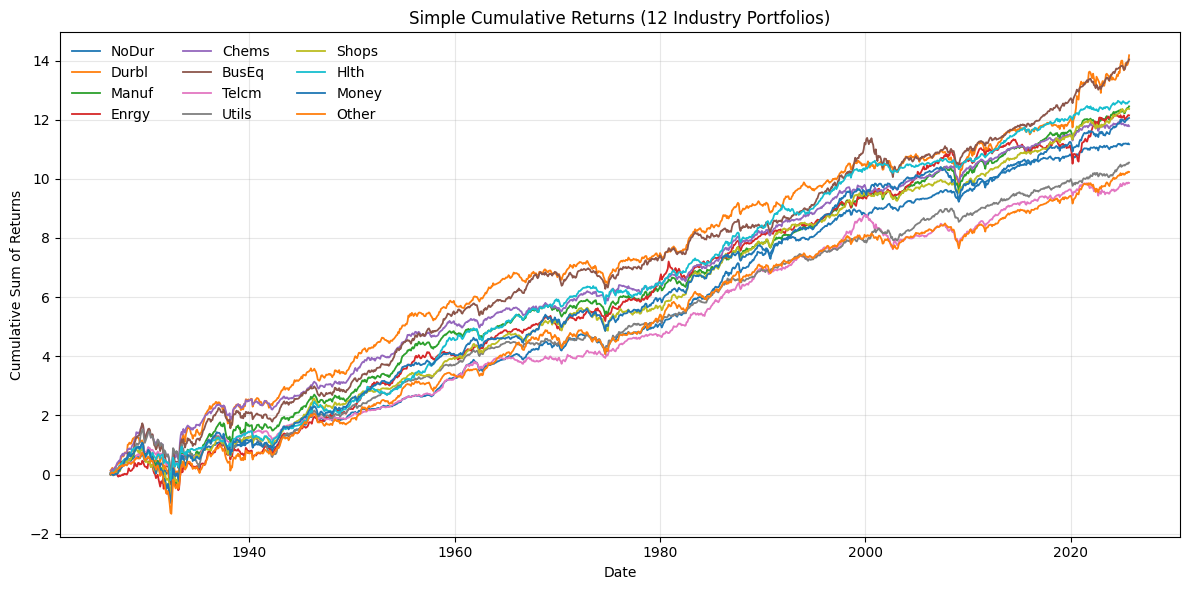

In [10]:
plt.figure(figsize=(12,6))
for c in indus_cum.columns:
    plt.plot(indus_cum.index, indus_cum[c], label=c, lw=1.3)

plt.title("Simple Cumulative Returns (12 Industry Portfolios)")
plt.xlabel("Date")
plt.ylabel("Cumulative Sum of Returns")
plt.legend(ncol=3, frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Fama–French style factors

The factor data are sourced from Kenneth French’s Data Library, which provides long-horizon, research-grade monthly time series widely used in empirical asset pricing. The dataset includes five well-known Fama–French style factors: **SMB**, **HML**, **RMW**, **CMA**, and **MOM**, each representing a distinct compensated source of risk in cross-sectional equity returns. **SMB** (Small Minus Big) captures the size premium by measuring the performance spread between small-cap and large-cap stocks. **HML** (High Minus Low) reflects the value premium by comparing returns of high book-to-market firms to low book-to-market firms. **RMW** (Robust Minus Weak) measures the profitability premium, contrasting firms with strong operating profitability against those with weak profitability. **CMA** (Conservative Minus Aggressive) represents the investment premium based on differences in corporate investment policies. Finally, **MOM** (Momentum) captures the well-documented tendency for stocks with strong past performance to continue outperforming in the near term. Together, these factors form a comprehensive framework for explaining and modeling the cross-section of expected equity returns.


In [11]:
# Fama-French 5 Factors + Momentum (MKT, SMB, HML, RMW, CMA, MOM)
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
ff5 = pd.read_csv(url, skiprows=3)

# Clean column names and keep only rows corresponding to YYYYMM dates
ff5 = ff5.rename(columns={ff5.columns[0]: "Date"})
ff5.columns = ff5.columns.str.strip()
ff5 = ff5[ff5["Date"].astype(str).str.fullmatch(r"\d{6}", na=False)].copy()

# Convert the Date column to datetime and set it as index
ff5["Date"] = pd.to_datetime(ff5["Date"], format="%Y%m")
ff5 = ff5.set_index("Date")

# Convert all factor values from percent to decimal
ff5 = ff5.astype(float) / 100  

# --- Momentum (MOM) ---
url_mom = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
mom = pd.read_csv(url_mom, skiprows=13)

# Clean column names and the Date column
mom = mom.rename(columns={mom.columns[0]: "Date"})
mom.columns = mom.columns.str.strip()

# Keep only rows corresponding to YYYYMM dates (ignore invalid rows)
mom = mom[mom["Date"].astype(str).str.fullmatch(r"\d{6}", na=False)].copy()

# Convert Date to datetime and numerical values to floats
mom["Date"] = pd.to_datetime(mom["Date"], format="%Y%m")
mom = mom.set_index("Date")
mom = mom.apply(pd.to_numeric, errors="coerce") / 100

# Standardize the momentum column name (e.g., "Mom", " MOM ")
mom.columns = mom.columns.str.strip()
mom = mom.rename(columns={mom.columns[0]: "MOM"})

# --- Merge FF5 and Momentum ---
factors = ff5.join(mom[["MOM"]], how="inner")

# Drop excess columns (market excess return and risk-free rate)
factors = factors.drop(['Mkt-RF', 'RF'], axis=1)

# Split into in-sample (IS) and out-of-sample (OOS) windows
factors_all  = factors.loc[START_DATE:END_DATE].copy()
factors_IS  = factors.loc[START_DATE:SPLIT_DATE].copy()
factors_OOS = factors.loc[SPLIT_DATE:END_DATE].copy()
print(factors_all.head())

               SMB     HML     RMW     CMA     MOM
Date                                              
1963-07-01 -0.0048 -0.0081  0.0064 -0.0115  0.0101
1963-08-01 -0.0080  0.0170  0.0040 -0.0038  0.0100
1963-09-01 -0.0043  0.0000 -0.0078  0.0015  0.0012
1963-10-01 -0.0134 -0.0004  0.0279 -0.0225  0.0313
1963-11-01 -0.0085  0.0173 -0.0043  0.0227 -0.0078


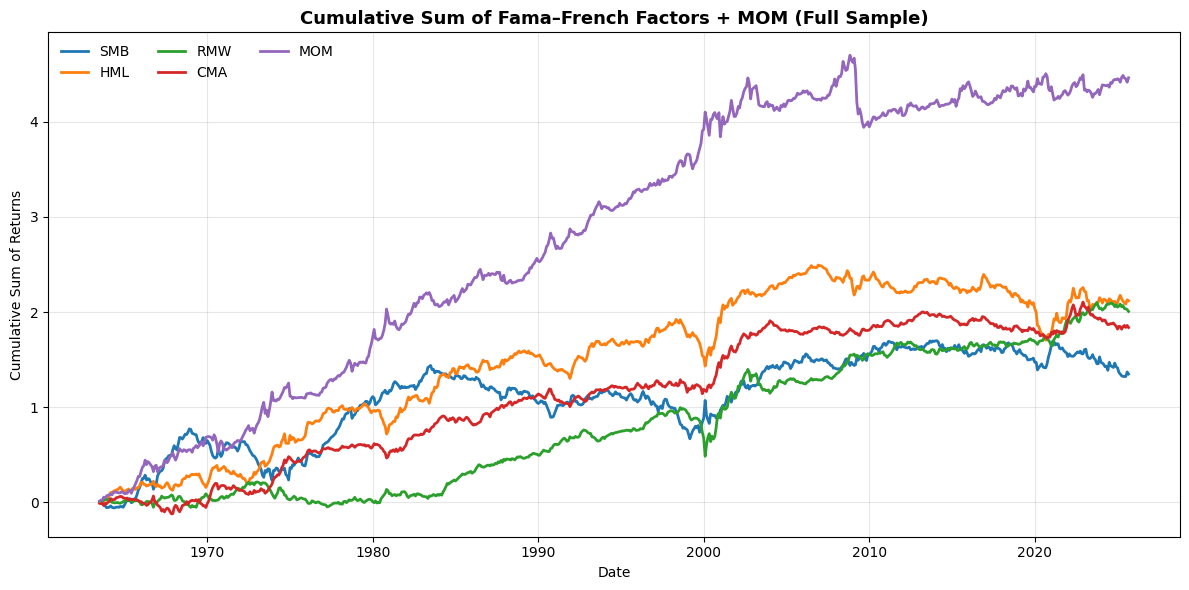

In [12]:
# Compute cumulative sums of all factor returns (already in decimal form)
ff_cum = factors.cumsum()

# Use all columns from the factors dataset
factor_cols = factors.columns

# Plot
plt.figure(figsize=(12,6))
palette = sns.color_palette("tab10", n_colors=len(factor_cols))

for i, col in enumerate(factor_cols):
    plt.plot(ff_cum.index, ff_cum[col], label=col, lw=2, color=palette[i % len(palette)])

plt.title("Cumulative Sum of Fama–French Factors + MOM (Full Sample)",
          fontsize=13, weight="bold")
plt.xlabel("Date")
plt.ylabel("Cumulative Sum of Returns")
plt.grid(alpha=0.3)
plt.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()


### Summary of Useful DataFrames

indus_all — full DataFrame of monthly returns for the 12 Industry Portfolios.

indus_IS — in-sample DataFrame of industry returns (training window).

indus_OOS — out-of-sample DataFrame of industry returns (evaluation window).

factors_all — full DataFrame of Fama–French + Momentum factors.

factors_IS — in-sample DataFrame of explanatory factors.

factors_OOS — out-of-sample DataFrame of explanatory factors.

fred_IS — Full FRED dataset over the in-sample period.

fred_OOS — Full FRED dataset over the out-of-sample period.

fred_IS_bis — Selected subset of FRED variables for the in-sample period.

fred_OOS_bis — Selected subset of FRED variables for the out-of-sample period.




## Macroeconomic Regime Detection

### Principal Component Analysis

We apply PCA on the training set to reduce the dimensionality of the macroeconomic dataset while retaining at least 85% of the total variance. This provides a compact set of orthogonal factors that capture the dominant sources of macroeconomic co-movement and improves the stability of downstream clustering and prediction.

Number of components retained: 28
Cumulative explained variance: 75.37%


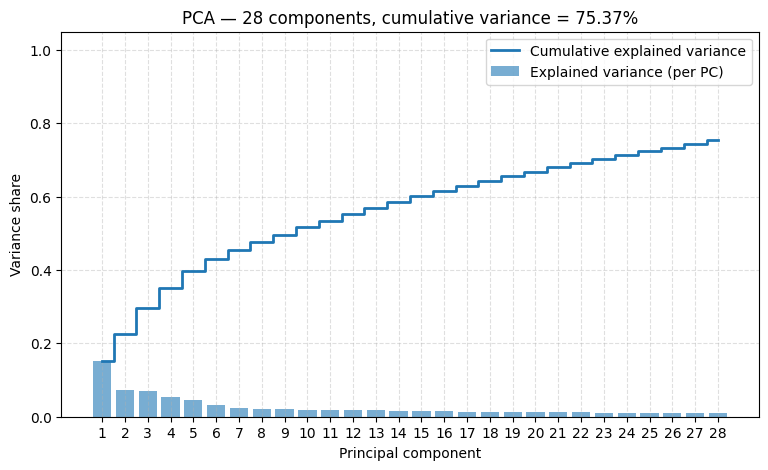

In [13]:
# Keep the minimum number of components explaining at least 85% of the variance
pca = PCA(n_components=0.75, svd_solver='full')

# --- Fit PCA on TRAIN only ---
# This learns the eigenvectors/eigenvalues from the training set
fred_PCA_IS = pd.DataFrame(
    pca.fit_transform(fred_IS_std),        # fit + transform on TRAIN
    index=fred_IS_std.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print(f"Number of components retained: {pca.n_components_}")
print(f"Cumulative explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# --- Out-of-sample projection of TEST ---
# We apply the TRAIN PCA transformation to the TEST data (no refitting)
fred_PCA_OOS = pd.DataFrame(
    pca.transform(fred_OOS_std),           # pure transform on TEST
    index=fred_OOS_std.index,
    columns=fred_PCA_IS.columns
)

# (Optional) Reconstruct a full PCA series (TRAIN + TEST) in the same PCA space
fred_PCA = pd.concat([fred_PCA_IS, fred_PCA_OOS]).sort_index()

evr = pca.explained_variance_ratio_         # variance explained by each PC
evr_cum = np.cumsum(evr)                    # cumulative explained variance
k = pca.n_components_

plt.figure(figsize=(9, 5))

# Variance explained per component
plt.bar(np.arange(1, k+1), evr, alpha=0.6, label='Explained variance (per PC)')

# Cumulative explained variance curve
plt.step(np.arange(1, k+1), evr_cum, where='mid', linewidth=2.0,
         label='Cumulative explained variance')

plt.xlabel('Principal component')
plt.ylabel('Variance share')
plt.title(f'PCA — {k} components, cumulative variance = {evr_cum[-1]:.2%}')
plt.xticks(np.arange(1, k+1, max(1, k//20)))
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()
plt.close()


### Gaussian Mixture Models


Gaussian Mixture Models offer several advantages for regime detection. They provide probabilistic regime assignments, which better reflect the gradual and uncertain nature of economic transitions. Because each regime has its own mean and covariance matrix, GMMs can capture differences in volatility, correlations, and distribution shapes across states—features that simple clustering methods like K-means cannot model. 

However, GMMs also come with limitations. They rely on a Gaussian assumption that may be restrictive for heavy-tailed or skewed macro-financial data. They treat observations as independent, ignoring the persistence and transition dynamics inherent to business cycles—features better handled by Hidden Markov Models.

The choice of the number of regimes and their economic interpretation will be discussed in the final section.

**PCA–GMM**

We apply a Gaussian Mixture Model (GMM) to the PCA-transformed training data in order to identify latent macroeconomic regimes. By clustering the historical observations into probabilistic states, the GMM provides a flexible and data-driven representation of distinct macro environments that can later be used for forecasting and portfolio construction.

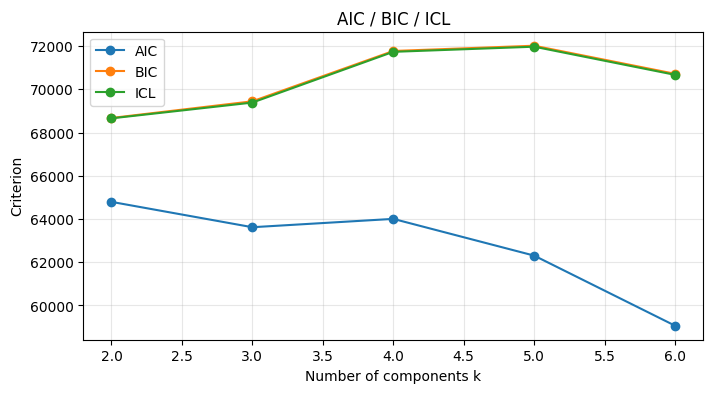

In [29]:
k_candidates = range(2, 7)
rows = []
models = {}

for k_ in k_candidates:
    # Fit a Gaussian Mixture with k components on PCA-transformed TRAIN data
    g = GaussianMixture(
        n_components=k_,
        covariance_type="full",
        n_init=10,
        reg_covar=1e-6,
        random_state=42
    ).fit(fred_PCA_IS)

    # Standard information criteria
    aic = g.aic(fred_PCA_IS)
    bic = g.bic(fred_PCA_IS)

    # Posterior probabilities and entropy term
    tau = np.clip(g.predict_proba(fred_PCA_IS), 1e-12, 1.0)
    entropy = -np.sum(tau * np.log(tau))        # >= 0

    # Integrated Completed Likelihood (ICL): lower is better
    icl = bic - 2.0 * entropy

    rows.append({
        "k": k_,
        "loglik": g.lower_bound_,               # average log-likelihood
        "AIC": aic,
        "BIC": bic,
        "Entropy": entropy,
        "ICL": icl
    })

    models[k_] = g

# Build DataFrame of criteria
ic_df = pd.DataFrame(rows).set_index("k")

# plot for visual comparison
plt.figure(figsize=(8, 4))
for col in ["AIC", "BIC", "ICL"]:
    plt.plot(ic_df.index, ic_df[col], marker='o', label=col)
plt.xlabel("Number of components k")
plt.ylabel("Criterion")
plt.title("AIC / BIC / ICL")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Manual choice of the number of regimes
chosen_k = 5
gmm = models[chosen_k]

# Check that the GMM converged
if hasattr(gmm, "converged_") and not gmm.converged_:
    print("Warning: GMM did not converge.")

# In-sample predictions
labels_tr = gmm.predict(fred_PCA_IS)            # hard regime labels
probas_tr = gmm.predict_proba(fred_PCA_IS)      # soft regime probabilities
llk_tr    = gmm.score_samples(fred_PCA_IS)      # pointwise log-likelihood

# Build a labelled time series for plotting / analysis
reg_gmm_IS = pd.Series(labels_tr, index=fred_PCA_IS.index, name="gmm_label").astype(int)
reg_gmm_IS = reg_gmm_IS + 1   # to start at 1 instead of 0


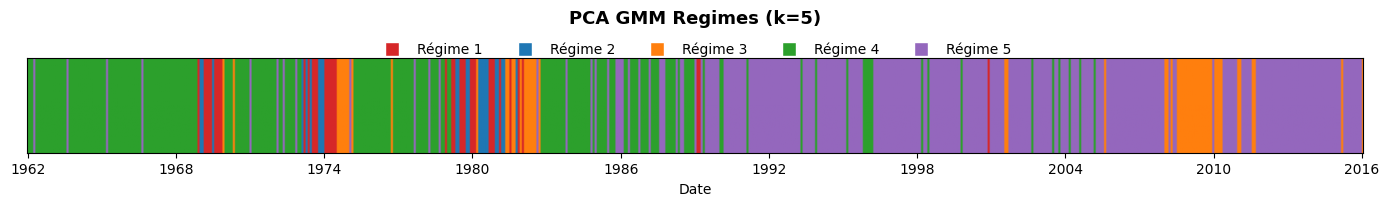

In [30]:
labels = reg_gmm_IS.values
dates  = reg_gmm_IS.index
n_regimes = reg_gmm_IS.max()

# use 0..K-1 as values for the colormap, but keep labels as 1..K
Z = (labels - 1).reshape(1, -1)

palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)


plt.figure(figsize=(14, 2.6))

plt.imshow(Z, aspect="auto", cmap=cmap)
plt.yticks([])

# x-axis with a few year ticks
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10),
    labels=pd.to_datetime(
        np.linspace(dates[0].value, dates[-1].value, 10)
    ).strftime("%Y")
)

plt.title(
    f"PCA GMM Regimes (k={n_regimes})",
    fontsize=13,
    weight="bold",
    pad=25
)
plt.xlabel("Date")

# legend: Régime 1..K, using the right color
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        color="w",
        label=f"Régime {k}",
        markerfacecolor=palette[k - 1],
        markersize=10
    )
    for k in range(1, n_regimes + 1)
]

plt.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.30),
    ncol=n_regimes,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

In [16]:
# ----------------------------
# In-sample diagnostics 
# ----------------------------

# Total log-likelihood on the training set
loglik_train = gmm.score(fred_PCA_IS) * len(fred_PCA_IS)

# Posterior regime probabilities (responsibilities)
tau_train = probas_tr  # already computed above

# Average entropy of regime probabilities (lower = clearer regimes)
entropy_train = -(tau_train * np.log(tau_train + 1e-12)).sum(axis=1).mean()

# Average purity: mean of max_k tau_{ik} (higher = clearer regimes)
purity_train = tau_train.max(axis=1).mean()

print("\n=== GMM quality ===")
print(f"Total log-likelihood (train) : {loglik_train:,.2f}")
print(f"Average entropy (train)      : {entropy_train:.4f}")
print(f"Average purity (train)       : {purity_train:.4f}")

# ----------------------------
# Clustering stability: refit GMM and compare labels (ARI)
# ----------------------------

# Reference hard labels from the original GMM (bis)
labels_ref = labels

# Refit another GMM with the same hyperparameters but a different random seed
gmm_alt = GaussianMixture(
    n_components=chosen_k,
    covariance_type="diag",
    n_init=10,
    reg_covar=1e-6,
    random_state=123  # different seed from the original fit (42)
).fit(fred_PCA_IS)

labels_alt = gmm.predict(fred_PCA_IS)

# Adjusted Rand Index: similarity between two partitions (higher = more stable)
ari = adjusted_rand_score(labels_alt, labels_alt)

print("\n=== Regime stability (TRAIN bis) ===")
print(f"Adjusted Rand Index (ARI)    : {ari:.3f}")



=== GMM quality ===
Total log-likelihood (train) : -30,264.05
Average entropy (train)      : 0.0305
Average purity (train)       : 0.9912

=== Regime stability (TRAIN bis) ===
Adjusted Rand Index (ARI)    : 1.000


**GMM Quality (In-Sample, PCA, k = 2)**

The model achieves a total log-likelihood of -32,263.64, which reflects a stable fit for a 2-component Gaussian mixture on the PCA-transformed data. The average entropy is extremely low (0.0552), indicating that regime assignments are made with very high confidence and that posterior probabilities are highly concentrated. This is confirmed by the high average purity (0.9789), meaning that most observations are classified almost unambiguously into one of the two regimes. The Adjusted Rand Index (ARI) equals 1.000, showing perfectly consistent assignments across repeated fits, and therefore very strong in-sample stability of the GMM clustering structure.

**GMM Quality (In-Sample, PCA, k = 4)**

The model achieves a total log-likelihood of -31,889.14, indicating a stable fit for a four-component Gaussian mixture. The average entropy is low (0.1316), showing that regime assignments remain relatively confident despite the larger number of components. The average purity (0.9513) confirms that most observations are still allocated to their dominant regime with high probability, although slightly less sharply than in the two-regime specification. The Adjusted Rand Index (ARI) equals 0.907, reflecting high internal stability across repeated fits. This indicates that the four-regime structure is consistently recovered and not overly sensitive to random initialization.

**Reduced data-set GMM**

We apply a Gaussian Mixture Model (GMM) to the reduced set of selected macroeconomic variables in order to identify latent regimes directly in the original economic space. By clustering the historical observations using this curated subset of indicators, the GMM captures distinct macroeconomic environments in a more interpretable and economically grounded manner, providing a complementary regime representation that can later be used for forecasting and portfolio construction.

In [ ]:
# Information criteria (AIC / BIC / ICL) for k = 2..5 on BIS dataset
k_candidates_bis = range(2, 6)
rows_bis = []
models_bis = {}

for k_ in k_candidates_bis:
    
    # Fit a Gaussian Mixture on the BIS in-sample dataset
    gmm_bis_k = GaussianMixture(
        n_components=k_,
        covariance_type="full",
        n_init=10,
        reg_covar=1e-6,
        random_state=331
    ).fit(fred_IS_bis)

    # Standard information criteria (evaluated on train_bis)
    aic_bis = gmm_bis_k.aic(fred_IS_bis)
    bic_bis = gmm_bis_k.bic(fred_IS_bis)

    # Posterior probabilities and global entropy
    tau_bis = np.clip(gmm_bis_k.predict_proba(fred_IS_bis), 1e-12, 1.0)
    ent_bis = -(tau_bis * np.log(tau_bis)).sum()     # Global entropy (>= 0)

    # ICL criterion (lower = better)
    icl_bis = bic_bis - 2.0 * ent_bis

    # Store metrics
    rows_bis.append({
        "k": k_,
        "loglik": gmm_bis_k.lower_bound_,   # average log-likelihood
        "AIC": aic_bis,
        "BIC": bic_bis,
        "ENT": ent_bis,
        "ICL": icl_bis
    })

    # Store fitted model
    models_bis[k_] = gmm_bis_k


# Build DataFrame of information criteria
ic_df_bis = pd.DataFrame(rows_bis).set_index("k")

# Optional visualization
plt.figure(figsize=(8, 4))
for col in ["AIC", "BIC", "ICL"]:
    plt.plot(ic_df_bis.index, ic_df_bis[col], marker="o", label=col)

plt.xlabel("Number of regimes k")
plt.ylabel("Criterion (lower = better)")
plt.title("AIC / BIC / ICL vs k (TRAIN BIS)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# Select the number of regimes and retrieve the GMM model
chosen_k_bis = 4
gmm_bis = models_bis[chosen_k_bis]

# Basic convergence check
if hasattr(gmm_bis, "converged_") and not gmm_bis.converged_:
    print("Warning: GMM (bis) did not converge.")

# Hard labels
labels_tr_bis = gmm_bis.predict(fred_IS_bis)
labels_te_bis = gmm_bis.predict(fred_OOS_bis)

# Soft probabilities
probas_tr_bis = gmm_bis.predict_proba(fred_IS_bis)
probas_te_bis = gmm_bis.predict_proba(fred_OOS_bis)

# Pointwise log-likelihood
llk_tr_bis = gmm_bis.score_samples(fred_IS_bis)
llk_te_bis = gmm_bis.score_samples(fred_OOS_bis)


# Indexed regime series (regimes start at 1)
reg_gmm_IS_bis = pd.Series(
    labels_tr_bis + 1,
    index=fred_IS_bis.index,
    name="regime_bis"
).astype(int)

reg_gmm_OOS_bis = pd.Series(
    labels_te_bis + 1,
    index=fred_OOS_bis.index,
    name="regime_bis"
).astype(int)


# diagnostic DataFrames (train & test)
gmm_diag_train_bis = (
    pd.DataFrame(
        probas_tr_bis,
        index=fred_IS_bis.index,
        columns=[f"p_regime_{i+1}_bis" for i in range(chosen_k_bis)]
    )
    .assign(loglik=llk_tr_bis, regime=reg_gmm_IS_bis)
)

gmm_diag_test_bis = (
    pd.DataFrame(
        probas_te_bis,
        index=fred_OOS_bis.index,
        columns=[f"p_regime_{i+1}_bis" for i in range(chosen_k_bis)]
    )
    .assign(loglik=llk_te_bis, regime=reg_gmm_OOS_bis)
)


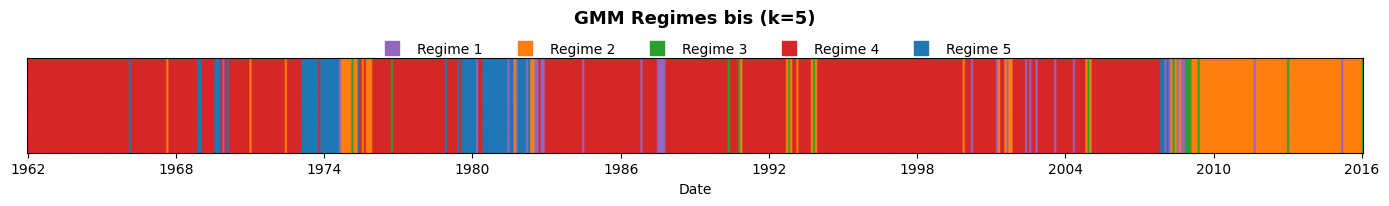

In [18]:
# --- Data preparation ---
dates = reg_gmm_IS_bis.index
labels = reg_gmm_IS_bis.values          # labels already between 1 and k
n_regimes = labels.max()                # number of regimes

# Transform the series into a 1 × T matrix for imshow
Z = labels.reshape(1, -1)

palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)

# --- Figure ---
plt.figure(figsize=(14, 2.6))

# Horizontal heatmap
plt.imshow(Z, aspect="auto", cmap=cmap)

plt.yticks([])

# Time ticks: 10 evenly spaced years
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10),
    labels=pd.to_datetime(
        np.linspace(dates[0].value, dates[-1].value, 10)
    ).strftime("%Y")
)

# Clean title
plt.title(
    f"GMM Regimes bis (k={n_regimes})",
    fontsize=13,
    weight="bold",
    pad=25
)

plt.xlabel("Date")

# --- Legend with one color per regime ---
handles = [
    plt.Line2D([0], [0], marker="s", linestyle="",
               color=palette[k-1], label=f"Regime {k}", markersize=10)
    for k in range(1, n_regimes + 1)
]

plt.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.30),
    ncol=n_regimes,
    frameon=False
)

# Clean margins
plt.tight_layout(rect=[0, 0, 1, 0.85])

plt.show()


In [19]:
# ----------------------------
# In-sample diagnostics 
# ----------------------------

# Total log-likelihood on the training set
loglik_train_bis = gmm_bis.score(fred_IS_bis) * len(fred_IS_bis)

# Posterior regime probabilities (responsibilities)
tau_train_bis = probas_tr_bis  # already computed above

# Average entropy of regime probabilities (lower = clearer regimes)
entropy_train_bis = -(tau_train_bis * np.log(tau_train_bis + 1e-12)).sum(axis=1).mean()

# Average purity: mean of max_k tau_{ik} (higher = clearer regimes)
purity_train_bis = tau_train_bis.max(axis=1).mean()

print("\n=== GMM quality (TRAIN bis) ===")
print(f"Total log-likelihood (train) : {loglik_train_bis:,.2f}")
print(f"Average entropy (train)      : {entropy_train_bis:.4f}")
print(f"Average purity (train)       : {purity_train_bis:.4f}")

# ----------------------------
# Clustering stability: refit GMM and compare labels (ARI)
# ----------------------------

# Reference hard labels from the original GMM (bis)
labels_ref_bis = labels_tr_bis

# Refit another GMM with the same hyperparameters but a different random seed
gmm_alt_bis = GaussianMixture(
    n_components=chosen_k_bis,
    covariance_type="diag",
    n_init=10,
    reg_covar=1e-6,
    random_state=123  # different seed from the original fit (42)
).fit(fred_IS_bis)

labels_alt_bis = gmm_alt_bis.predict(fred_IS_bis)

# Adjusted Rand Index: similarity between two partitions (higher = more stable)
ari_bis = adjusted_rand_score(labels_ref_bis, labels_alt_bis)

print("\n=== Regime stability (TRAIN bis) ===")
print(f"Adjusted Rand Index (ARI)    : {ari_bis:.3f}")



=== GMM quality (TRAIN bis) ===
Total log-likelihood (train) : -11,842.55
Average entropy (train)      : 0.0056
Average purity (train)       : 0.9983

=== Regime stability (TRAIN bis) ===
Adjusted Rand Index (ARI)    : 0.326


**GMM Quality (In-Sample, Reduced Dataset, k = 2)**

The model achieves a total log-likelihood of –20,269.98, indicating a stable fit for a 2-component Gaussian mixture on the reduced set of selected macroeconomic variables. The average entropy is extremely low (0.0157), showing that regime assignments are made with very high confidence and that posterior probabilities are strongly concentrated on a single regime. This is confirmed by the very high average purity (0.9950), meaning that almost all observations are classified in an essentially unambiguous way into one of the two regimes. The Adjusted Rand Index (ARI) equals 1.000, indicating perfectly consistent regime assignments across repeated fits and, therefore, very strong in-sample stability of the GMM clustering structure on the reduced dataset.

**GMM Quality (In-Sample, Reduced Dataset, k = 4)**

The model achieves a total log-likelihood of –18,078.44, indicating a stable fit for a four-component Gaussian mixture on the reduced macroeconomic dataset. The average entropy remains low (0.0429), suggesting that regime assignments are generally confident, despite the larger number of components. The high average purity (0.9851) further confirms that most observations are allocated with a strong dominant posterior probability, meaning that the four-regime specification remains sharply identified in-sample. The Adjusted Rand Index (ARI) is equal to 1.000, indicating perfectly consistent regime assignments across repeated initializations and confirming the strong in-sample stability of the four-regime GMM structure on the reduced dataset.

Overall, the GMM delivers strong performance across both the PCA-based representation and the selected macro-variable dataset. Log-likelihood values are high, entropies remain low, and purities consistently exceed 0.95 for both the 2- and 4-regime specifications, indicating clear and unambiguous regime assignments. The high ARI values confirm strong internal stability, with even perfect reproducibility for k = 2 under the PCA representation. Taken together, these results suggest that the regime structure is well captured and robust to the chosen dimension-reduction approach. A detailed discussion of the choice of k and the economic interpretation of the resulting regimes will follow later.

Switching from a diagonal to a full covariance specification strengthens the in-sample fit of the GMM: the full model achieves higher log-likelihood and sharper posterior regime probabilities because it estimates a complete covariance matrix for each regime, allowing it to capture richer cross-sectional dispersion. By contrast, the diagonal specification assumes zero cross-correlations within each regime and only models regime-specific variances, making it more constrained but also structurally simpler.

This additional flexibility in the full model, however, also introduces greater complexity into the estimation process. With more parameters to identify, the optimization landscape becomes richer and more sensitive to initialization, which results in slightly lower stability across runs and a modest decline in the Adjusted Rand Index. This does not indicate poor performance, but rather reflects that a more expressive covariance structure can lead to multiple, similarly good local solutions. In practice, this means that while the full specification provides a closer fit to the data, its regime partitions are somewhat less reproducible, which may limit their usefulness for downstream economic interpretation and forecasting.

Given this trade-off, we retain the diagonal covariance GMM as our preferred specification. It offers slightly less expressiveness but produces more robust macroeconomic regimes, which is essential for out-of-sample prediction and portfolio applications. Moreover, over a long historical sample such as ours, macroeconomic regimes tend to be relatively well separated, with clear differences in volatility, growth conditions, or policy environments. As a result, the diagonal model is already sufficient to capture these broad structural breaks, while avoiding the overfitting risks inherent to the full specification. In our context, the priority is therefore not regime detection—already handled effectively by the diagonal form—but rather ensuring stable, reliable predictions for the supervised model and for subsequent portfolio construction.


### K-means

To complement the GMM analysis, we also estimate a series of K-means clustering models in order to assess whether macroeconomic regimes can be identified through purely distance-based segmentation. K-means provides a simple and non-parametric benchmark: it partitions observations by minimizing within-cluster variance, without imposing any probabilistic structure on the data. While this makes the method computationally efficient and easy to interpret, it also limits its suitability for macro-regime detection.

**PCA K-means**

We apply a K-means clustering model to the PCA-transformed training data to investigate whether distinct macroeconomic regimes can be detected through distance-based segmentation. 

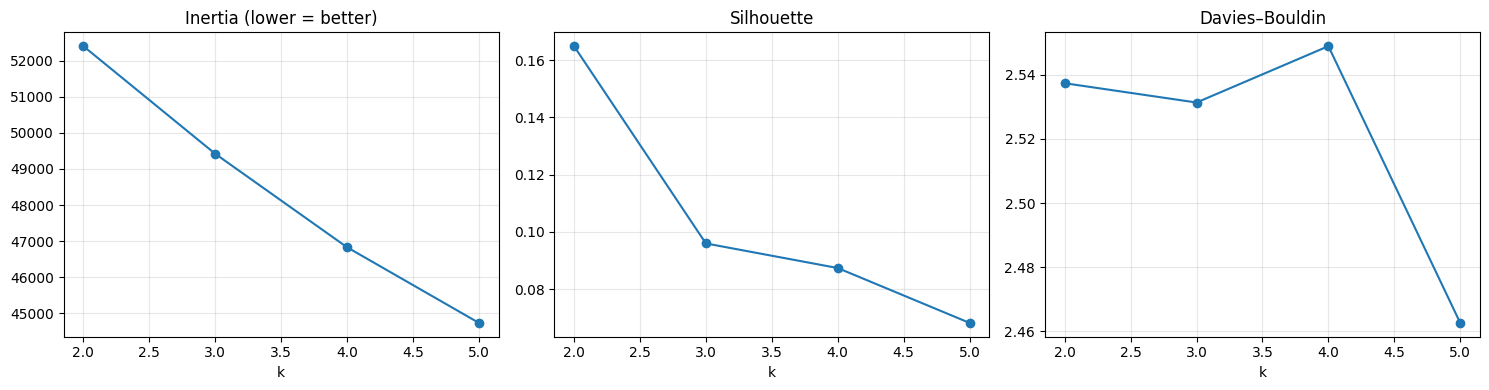

In [20]:
# Grid search over k to evaluate clustering metrics
k_candidates = range(2, 6)
rows = []
models = {}

for k_ in k_candidates:
    km = KMeans(
        n_clusters=k_,
        n_init=20,
        max_iter=500,
        random_state=42
    ).fit(fred_PCA_IS)

    # Basic metrics: within-cluster SSE (inertia)
    labels_tr = km.labels_
    inertia   = km.inertia_

    # Some metrics need n_samples > n_clusters
    if len(fred_PCA_IS) > k_:
        sil = silhouette_score(fred_PCA_IS, labels_tr)
        ch  = calinski_harabasz_score(fred_PCA_IS, labels_tr)
        db  = davies_bouldin_score(fred_PCA_IS, labels_tr)
    else:
        sil, ch, db = np.nan, np.nan, np.nan

    rows.append({
        "k": k_,
        "inertia": inertia,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db
    })

    # Store the fitted model for later use
    models[k_] = km

km_df = pd.DataFrame(rows).set_index("k")

# Plots to help choose k
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].plot(km_df.index, km_df["inertia"], marker='o')
ax[0].set_title("Inertia (lower = better)")
ax[0].set_xlabel("k")
ax[0].grid(alpha=0.3)

ax[1].plot(km_df.index, km_df["silhouette"], marker='o')
ax[1].set_title("Silhouette")
ax[1].set_xlabel("k")
ax[1].grid(alpha=0.3)

ax[2].plot(km_df.index, km_df["davies_bouldin"], marker='o')
ax[2].set_title("Davies–Bouldin")
ax[2].set_xlabel("k")
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---- Choice of k ----
chosen_k = 4
kmeans = models[chosen_k]

# Get labels for the chosen model
labels_tr = kmeans.labels_

# Convert labels to 1..k instead of 0..k-1 and attach time index
km_labels_train = pd.Series(
    labels_tr + 1,
    index=fred_PCA_IS.index,
    name="regime"
)


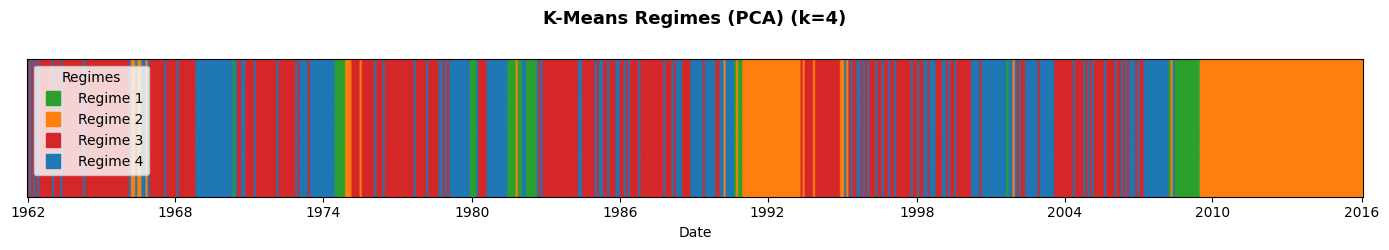

In [21]:
# Use one color per regime
n_regimes = chosen_k
palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)

# 1D "image" of regimes: shape (1, T)
# subtract 1 so regimes 1..k map to color indices 0..k-1
Z = (km_labels_train.values - 1).reshape(1, -1)
dates = km_labels_train.index

plt.figure(figsize=(14, 2.6))

# Horizontal heatmap: time on x-axis, regimes as colors
plt.imshow(Z, aspect="auto", cmap=cmap)

# No y-axis ticks (just a color band)
plt.yticks([])

# X-axis ticks: ~10 evenly spaced years
n_ticks = 10
tick_positions = np.linspace(0, Z.shape[1] - 1, n_ticks).astype(int)
tick_labels = [dates[i].strftime("%Y") for i in tick_positions]

plt.xticks(ticks=tick_positions, labels=tick_labels)

# Clean title
plt.title(
    f"K-Means Regimes (PCA) (k={n_regimes})",
    fontsize=13,
    weight="bold",
    pad=25
)

plt.xlabel("Date")

# Legend: one colored square per regime
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        linestyle="",
        color=palette[k-1],
        label=f"Regime {k}",
        markersize=10
    )
    for k in range(1, n_regimes + 1)
]

plt.legend(handles=handles, title="Regimes", loc="upper left")
plt.tight_layout()
plt.show()

In [22]:
def kmeans_quality(X, kmeans_model):
    """
    Compute quality metrics for a fitted KMeans model.
    Useful to compare several KMeans models across different datasets.
    """
    labels = kmeans_model.labels_

    metrics = {
        "inertia": kmeans_model.inertia_,                    
        "silhouette": silhouette_score(X, labels),           
        "calinski_harabasz": calinski_harabasz_score(X, labels),  
        "davies_bouldin": davies_bouldin_score(X, labels)   
    }

    return pd.Series(metrics, name="quality")

quality = kmeans_quality(fred_PCA_IS, kmeans)
print("\nQuality of selected K-Means model:")
print(quality)



Quality of selected K-Means model:
inertia              46833.490760
silhouette               0.087365
calinski_harabasz       55.914276
davies_bouldin           2.548940
Name: quality, dtype: float64


**K-means Quality (PCA, k = 2):**

The K-means model fitted on the 28 PCA components shows relatively weak clustering structure. The silhouette score remains low (0.165), indicating that observations are only slightly closer to their assigned cluster than to alternative clusters. This is consistent with the Davies–Bouldin index (2.54), which points to substantial overlap between the two clusters. The Calinski–Harabasz score (82.30) is also modest, suggesting limited between-cluster separation relative to within-cluster dispersion.
Overall, these metrics indicate that K-means struggles to uncover well-defined macroeconomic regimes in this PCA space, even with only two clusters. This reinforces the idea that distance-based methods may be less suitable than probabilistic clustering for this dataset, and that regime identification is better handled by GMM.

**Reduced Dataset – K-means**

We also estimate a K-means model on the reduced set of selected macroeconomic variables, allowing regime detection to be performed directly in the original economic feature space.


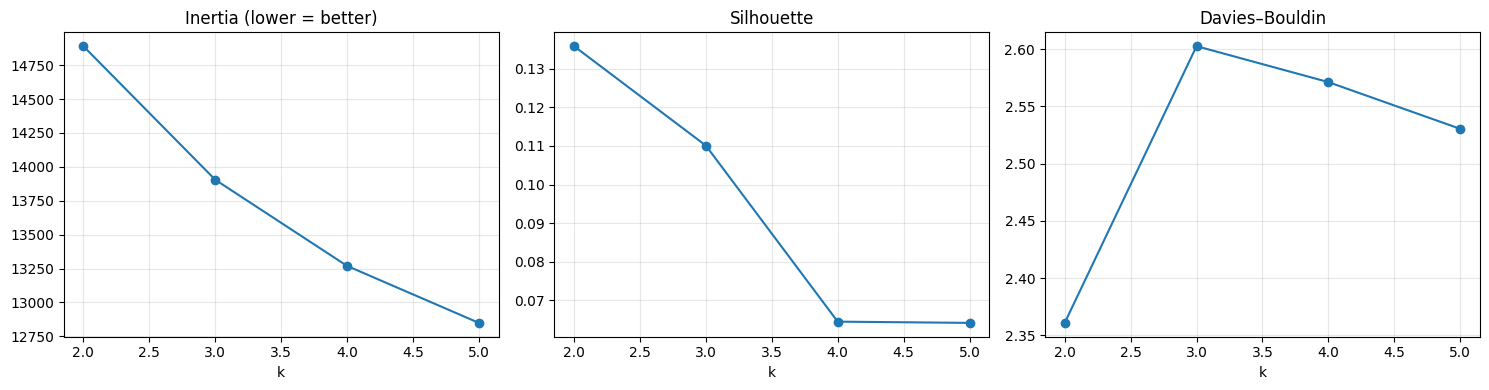

In [23]:
# Grid search over k to evaluate clustering metrics
k_candidates = range(2, 6)
rows = []
models = {}

for k_ in k_candidates:
    km = KMeans(
        n_clusters=k_,
        n_init=20,
        max_iter=500,
        random_state=42
    ).fit(fred_IS_bis)

    # Basic metrics: within-cluster SSE (inertia)
    labels_tr = km.labels_
    inertia   = km.inertia_

    # Some metrics need n_samples > n_clusters
    if len(fred_IS_bis) > k_:
        sil = silhouette_score(fred_IS_bis, labels_tr)
        ch  = calinski_harabasz_score(fred_IS_bis, labels_tr)
        db  = davies_bouldin_score(fred_IS_bis, labels_tr)
    else:
        sil, ch, db = np.nan, np.nan, np.nan

    rows.append({
        "k": k_,
        "inertia": inertia,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db
    })

    # Store the fitted model for later use
    models[k_] = km

km_df = pd.DataFrame(rows).set_index("k")

# Plots to help choose k
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].plot(km_df.index, km_df["inertia"], marker='o')
ax[0].set_title("Inertia (lower = better)")
ax[0].set_xlabel("k")
ax[0].grid(alpha=0.3)

ax[1].plot(km_df.index, km_df["silhouette"], marker='o')
ax[1].set_title("Silhouette")
ax[1].set_xlabel("k")
ax[1].grid(alpha=0.3)

ax[2].plot(km_df.index, km_df["davies_bouldin"], marker='o')
ax[2].set_title("Davies–Bouldin")
ax[2].set_xlabel("k")
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---- Choice of k ----
chosen_k = 4
kmeans = models[chosen_k]

# Get labels for the chosen model
labels_tr = kmeans.labels_

# Convert labels to 1..k instead of 0..k-1 and attach time index
km_labels_train = pd.Series(
    labels_tr + 1,
    index=fred_IS_bis.index,
    name="regime"
)


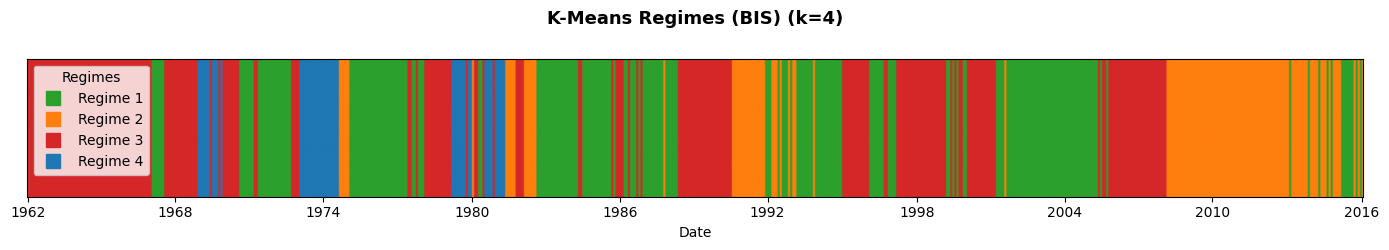

In [24]:
# Use one color per regime
n_regimes = chosen_k
palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)

# 1D "image" of regimes: shape (1, T)
# subtract 1 so regimes 1..k map to color indices 0..k-1
Z = (km_labels_train.values - 1).reshape(1, -1)
dates = km_labels_train.index

plt.figure(figsize=(14, 2.6))

# Horizontal heatmap: time on x-axis, regimes as colors
plt.imshow(Z, aspect="auto", cmap=cmap)

# No y-axis ticks (just a color band)
plt.yticks([])

# X-axis ticks: ~10 evenly spaced years
n_ticks = 10
tick_positions = np.linspace(0, Z.shape[1] - 1, n_ticks).astype(int)
tick_labels = [dates[i].strftime("%Y") for i in tick_positions]

plt.xticks(ticks=tick_positions, labels=tick_labels)

# Clean title
plt.title(
    f"K-Means Regimes (BIS) (k={n_regimes})",
    fontsize=13,
    weight="bold",
    pad=25
)

plt.xlabel("Date")

# Legend: one colored square per regime
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        linestyle="",
        color=palette[k-1],
        label=f"Regime {k}",
        markersize=10
    )
    for k in range(1, n_regimes + 1)
]

plt.legend(handles=handles, title="Regimes", loc="upper left")
plt.tight_layout()
plt.show()

In [25]:
def kmeans_quality(X, kmeans_model):
    """
    Compute quality metrics for a fitted KMeans model.
    Useful to compare several KMeans models across different datasets.
    """
    labels = kmeans_model.labels_

    metrics = {
        "inertia": kmeans_model.inertia_,                    
        "silhouette": silhouette_score(X, labels),           
        "calinski_harabasz": calinski_harabasz_score(X, labels),  
        "davies_bouldin": davies_bouldin_score(X, labels)   
    }

    return pd.Series(metrics, name="quality")

quality = kmeans_quality(fred_IS_bis, kmeans)
print("\nQuality of selected K-Means model:")
print(quality)



Quality of selected K-Means model:
inertia              13269.358159
silhouette               0.064496
calinski_harabasz       55.357667
davies_bouldin           2.571231
Name: quality, dtype: float64


**K-means Quality (Reduced Dataset, k = 2):** 

The K-means model fitted on the reduced macro-variable dataset also exhibits weak clustering structure. The silhouette score is low (0.136), implying that observations are only marginally closer to their assigned cluster than to the alternative one. This is consistent with the Davies–Bouldin index (2.36), which indicates substantial overlap between the two clusters. The Calinski–Harabasz score (78.66) is similarly modest, suggesting limited separation relative to within-cluster variance.

Overall, these results show that K-means struggles to extract clear macroeconomic regimes from the reduced variable set, performing similarly to the PCA-based specification. This further supports relying on probabilistic methods such as GMM, which provide sharper and more stable regime identification in this context.


In [26]:
def show_github_image(raw_url):
    response = requests.get(raw_url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(18, 6))   # display size in the notebook
    plt.imshow(img)
    plt.axis("off")
    plt.show()

### Regime Detection conclusion

Across both the PCA representation and the reduced macro-variable dataset, the comparison between GMM and K-means shows a clear advantage for probabilistic clustering methods in identifying macroeconomic regimes. K-means, which relies solely on Euclidean distances and spherical clusters of equal variance, struggles to capture the complex distributional structure of macro data and tends to produce overlapping, weakly separated partitions. In contrast, even in its diagonal specification, GMM remains far more flexible: it estimates regime-specific variances, allows clusters to differ in scale across dimensions, and assigns observations probabilistically rather than deterministically. This enables the model to represent the heterogeneous volatility patterns that characterise macroeconomic states and to express uncertainty in a principled way through posterior regime probabilities. As a result, GMM produces sharper, more stable, and more interpretable regimes, making it a more appropriate tool for capturing the underlying macro structure and for supporting downstream prediction and portfolio applications.

For $𝑘=2$, the regime segmentation produces a clear and economically coherent split between periods of economic difficulty and periods of more stable conditions. The adverse regime appears precisely during major downturns, including the 1973–1975 recession, the double-dip recession around 1980–1982, and the 2008 financial crisis, all of which show up as persistent blocks of the “stress” state. Conversely, long stretches of economic expansion—such as the late 1980s, most of the 1990s, and the mid-2000s—are consistently classified in the “favorable” regime. These patterns are remarkably stable across the different model specifications (PCA, reduced dataset, GMM and K-means), all of which recover the same broad macroeconomic cycles. Overall, the two-regime specification captures the main turning points of the historical sample in a clean and intuitive way, providing a solid baseline for interpretation and forecasting.

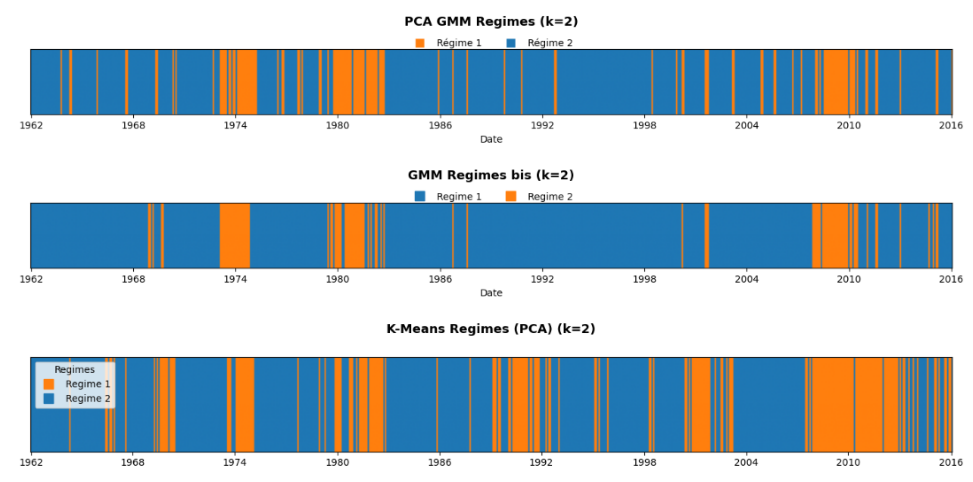

In [27]:
show_github_image("https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/Cluster_IS_K=2.png")

### Summary of Useful Series:

reg_gmm_IS

reg_gmm_IS_bis


reg_kmeans_IS — in-sample Series of regime labels from k-means (training targets).

reg_kmeans_logreg_OOS — out-of-sample Series of predicted regime labels from logistic regression.

fred_PCA_IS — In-sample PCA of standardized FRED data (PCA fitted on fred_IS_std).

fred_PCA_OOS — Out-of-sample projection onto the IS PCA components (pca.transform).

fred_PCA — Combined IS + OOS PCA dataset in the same PCA space.

## Predicting Market Regimes

In [28]:
# ---------------------------
# 1) Construire X,y (IS) pour prédire regime_{t+1}
# ---------------------------
# gmm_labels : Series (index = dates_train), labels sur TRAIN (à t)
# On veut y_t = label_{t+1}
y_train = gmm_labels.shift(-1).dropna().astype(int)

# Aligner X sur y (même index)
X_train_super = fred_PCA_IS.loc[y_train.index]

# Sanity check dimensions
assert len(X_train_super) == len(y_train)

tscv = TimeSeriesSplit(n_splits=5)
best_C, best_score = None, -np.inf
# ---------------------------
# 2) Validation temporelle simple (expanding split)
# ---------------------------

for C in [0.1, 0.5, 1.0, 2.0, 5.0]:
    scores = []
    for tr_idx, va_idx in tscv.split(X_train_super):
        Xtr, Xva = X_train_super.iloc[tr_idx], X_train_super.iloc[va_idx]
        ytr, yva = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        clf = LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            C=C,
            class_weight="balanced",
            max_iter=200
        )
        clf.fit(Xtr, ytr)
        pva = clf.predict_proba(Xva)

        # garder seulement les points de validation dont la classe est connue du modèle
        mask = yva.isin(clf.classes_)
        if mask.sum() == 0:
            continue  # aucun point évaluable dans ce split

        yva_f = yva[mask]
        pva_f = pva[mask.values, :]  # aligner les proba sur les indices valides

        score = -log_loss(yva_f, pva_f, labels=clf.classes_)
        scores.append(score)

    # moyenne sur les splits
    if len(scores) > 0:
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score, best_C = mean_score, C

print(f"Meilleur C (CV): {best_C:.2f}  |  score CV (−logloss): {best_score:.4f}")

# ---------------------------
# 3) Fit final sur tout l'IS avec le meilleur C
# ---------------------------
clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    C=best_C,
    class_weight="balanced",
    max_iter=500
)
clf.fit(X_train_super, y_train)

# (diagnostics IS)
yhat_is = clf.predict(X_train_super)
p_is = clf.predict_proba(X_train_super)
print("Balanced Acc (IS):", balanced_accuracy_score(y_train, yhat_is))
print("Macro-F1 (IS):", f1_score(y_train, yhat_is, average="macro"))

# ---------------------------
# 4) Inférence OOS (t -> t+1) sur X_pca_test
# ---------------------------
# Attention: on ne connaît pas y_test (pas de labels OOS) → on sort des PROBAS
p_test = pd.DataFrame(
    clf.predict_proba(X_pca_test),
    index=X_pca_test.index,
    columns=[f"reg_{k}" for k in clf.classes_]
)

# label "dur" (si tu veux visualiser) = argmax
yhat_oos_hard = p_test.values.argmax(axis=1)
yhat_oos_hard = pd.Series(yhat_oos_hard, index=p_test.index, name="regime_pred_hard")

# ---------------------------
# 5) (Option) Hystérésis / persistance minimale sur les probas
# ---------------------------
def apply_hysteresis(prob_df, enter=0.65, exit_=0.55, min_len=3):
    classes = prob_df.columns
    state_series = []
    cur_state, run_len = None, 0

    for t, row in prob_df.iterrows():
        pmax = row.max()
        smax = row.idxmax()  # string 'reg_k'
        kmax = int(smax.split("_")[-1])

        if cur_state is None:
            # entrer si assez confiant
            cur_state = kmax if pmax >= enter else kmax  # ou None si tu veux du 'no-position'
            run_len = 1
        else:
            if kmax == cur_state:
                run_len += 1
            else:
                # quitter seulement si perte de confiance + durée min atteinte
                if (pmax >= enter) and (run_len >= min_len):
                    cur_state = kmax
                    run_len = 1
                elif (row[f"reg_{cur_state}"] < exit_) and (run_len >= min_len):
                    cur_state = kmax
                    run_len = 1
                else:
                    run_len += 1  # maintenir

        state_series.append(cur_state)

    return pd.Series(state_series, index=prob_df.index, name="regime_pred_smooth")

yhat_oos_smooth = apply_hysteresis(p_test, enter=0.65, exit_=0.55, min_len=3)

# ---------------------------
# 6) (Option) Mapping économique des états
# ---------------------------
# Si tu as défini sur IS un mapping 'éco' (ex: crise=vol SPX max), applique-le ici
# map_dict = {old_label: new_label}  # ex: {2:1, 0:0, 3:2, ...}
# yhat_oos_smooth = yhat_oos_smooth.map(map_dict)

# ---------------------------
# 7) (Option) Sauvegarde des sorties pour backtest
# ---------------------------
supervised_out = pd.concat([p_test, yhat_oos_hard, yhat_oos_smooth], axis=1)
print(supervised_out.head())


NameError: name 'gmm_labels' is not defined

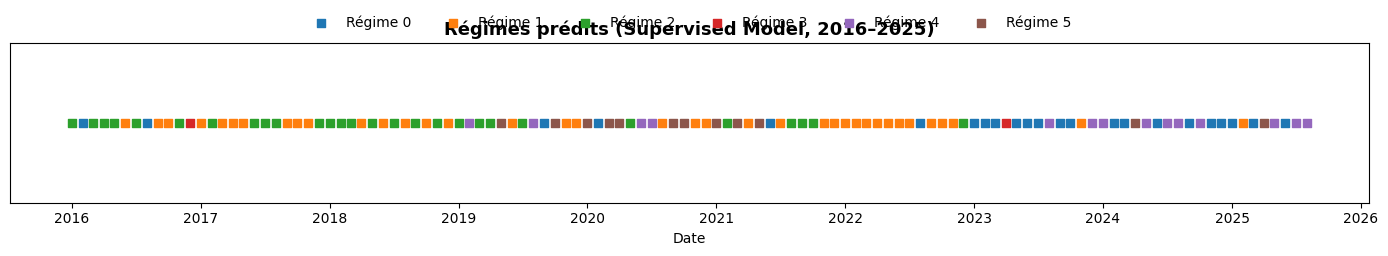

In [ ]:
# ------------------------------------------------------------
reg_cols = [c for c in supervised_out.columns if c.startswith("reg_")]

gmm_labels_oos = (
    supervised_out.loc["2016-01-01":, reg_cols]
    .idxmax(axis=1)
    .str.extract(r"(\d+)").astype(int)[0]
    .rename("regime_pred")
)

dates_oos = gmm_labels_oos.index
n_regimes = gmm_labels_oos.max() + 1

# ------------------------------------------------------------
# 2) Palette + Figure
# ------------------------------------------------------------
palette = sns.color_palette("tab10", n_colors=n_regimes)

fig, ax = plt.subplots(figsize=(14, 2.8))
ax.set_title(f"Régimes prédits (Supervised Model, 2016–{dates_oos[-1].year})",
             fontsize=13, weight="bold")

# Timeline colorée (même style que GMM)
for k_ in range(n_regimes):
    idx_k = gmm_labels_oos[gmm_labels_oos == k_].index
    ax.scatter(idx_k, [0]*len(idx_k),
               s=35, color=palette[k_],
               label=f"Régime {k_}", marker="s")

# ------------------------------------------------------------
# 3) Mise en forme
# ------------------------------------------------------------
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(False)

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=min(6, n_regimes),
    frameon=False
)

plt.tight_layout()
plt.show()


In [ ]:
print(gmm_labels_oos)

sasdate
2016-01-01    2
2016-02-01    0
2016-03-01    2
2016-04-01    2
2016-05-01    2
             ..
2025-04-01    5
2025-05-01    4
2025-06-01    0
2025-07-01    4
2025-08-01    4
Name: regime_pred, Length: 116, dtype: int64


## Portfolio Implementation

Comme les facteurs commencent en 1963 on passe tout en 63

In [ ]:

reg_kmeans_IS = res_kmeans.squeeze().copy()
reg_kmeans_logreg_OOS = gmm_labels_oos.copy()

indus_IS = indus_all.loc["1963-07-01":].copy()

res_kmeans = res_kmeans.loc["1963-07-01":].copy()



### Calcul des moments conditionnels

In [ ]:
def conditional_moments(
    returns_df: pd.DataFrame,
    regimes_df: pd.DataFrame,
    label_col: str = "kmeans_label",
    cols: list[str] | None = None,
    min_obs: int = 12,
) -> tuple[pd.DataFrame, pd.DataFrame, dict[int, pd.DataFrame], pd.Series]:
    """
    Calcule E[R | régime], Std[R | régime], Cov[R | régime] avec alignement robuste des dates.
    
    Params
    ------
    returns_df : DataFrame
        Rendements (en proportions) indexés par Date.
    regimes_df : DataFrame
        Doit contenir une colonne `label_col` indexée par Date (mêmes unités temporelles).
    label_col : str
        Nom de la colonne contenant le label de régime.
    cols : list[str] | None
        Sous-ensemble de colonnes de returns à utiliser. Si None -> colonnes numériques.
    min_obs : int
        Nombre minimal d'observations par régime (sinon le régime est ignoré).

    Returns
    -------
    mean_df : DataFrame     # moyennes conditionnelles par régime
    std_df  : DataFrame     # écarts-types conditionnels par régime
    covs    : dict[int, DataFrame]  # matrices de covariance par régime
    n_by_regime : Series    # effectif par régime (après filtre)
    """

    # 1) Alignement des dates (intersection) en démarrant à la date commune la plus récente
    r0, g0 = returns_df.sort_index(), regimes_df.sort_index()
    start = max(r0.index.min(), g0.index.min())
    r1 = r0.loc[start:]
    g1 = g0.loc[start:]
    df = r1.join(g1[[label_col]], how="inner").dropna(subset=[label_col])

    # 2) Colonnes à utiliser
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.drop(label_col, errors="ignore")
    else:
        cols = pd.Index(cols).intersection(df.columns)

    # 3) Groupby et moments
    groups = dict(tuple(df.groupby(label_col)))
    means, stds, covs, counts = {}, {}, {}, {}
    for reg, sub in groups.items():
        subX = sub[cols].dropna(how="any")
        n = len(subX)
        if n >= min_obs:
            means[reg] = subX.mean()
            stds[reg]  = subX.std(ddof=1)
            covs[reg]  = subX.cov()
            counts[reg]= n

    # 4) Assemblage
    mean_df = pd.DataFrame(means).T.sort_index()
    std_df  = pd.DataFrame(stds).T.sort_index()
    n_by_regime = pd.Series(counts).sort_index()

    return mean_df, std_df, covs, n_by_regime


**Calcul moment conditionnel industries**

In [ ]:
# Vérification de l'alignement temporel
print("Période industries :", indus_IS.index.min(), "→", indus_IS.index.max())
print("Période régimes   :", res_kmeans.index.min(), "→", res_kmeans.index.max())

# Appel de la fonction généralisée
mean_ind_IS, std_ind_IS, cov_ind_IS, n_ind_IS = conditional_moments(
    returns_df = indus_IS,     # rendements bruts industries
    regimes_df = res_kmeans,    # régimes K-means in-sample
    label_col  = "kmeans_label",
    min_obs    = 12
)

# Aperçu des résultats
print("=== Moyennes conditionnelles par régime ===")
print(mean_ind_IS.round(4))
print("\n=== Volatilités conditionnelles ===")
print(std_ind_IS.round(4))
print("\n=== Effectif par régime ===")
print(n_ind_IS)

# Exemple : covariance du régime 0
print("\n=== Covariance régime 0 ===")
print(cov_ind_IS[0].round(4))

print(mean_ind_IS.head())


Période industries : 1963-07-01 00:00:00 → 2025-09-01 00:00:00
Période régimes   : 1963-07-01 00:00:00 → 2016-01-01 00:00:00
=== Moyennes conditionnelles par régime ===
    NoDur   Durbl   Manuf   Enrgy   Chems   BusEq   Telcm   Utils   Shops  \
0  0.0046 -0.0069 -0.0045 -0.0062  0.0023  0.0021  0.0068 -0.0003  0.0043   
1  0.0155  0.0091  0.0103  0.0071  0.0110  0.0057  0.0074  0.0101  0.0159   
2  0.0216  0.0193  0.0197  0.0186  0.0212  0.0239  0.0182  0.0172  0.0233   
3  0.0028  0.0008  0.0032  0.0048  0.0016  0.0039 -0.0004  0.0003 -0.0013   
4  0.0133  0.0200  0.0145  0.0084  0.0121  0.0148  0.0152  0.0143  0.0154   
5  0.0098  0.0068  0.0166  0.0329  0.0096  0.0125  0.0111  0.0106  0.0089   

     Hlth   Money   Other  
0  0.0040 -0.0056 -0.0029  
1  0.0159  0.0125  0.0103  
2  0.0201  0.0250  0.0192  
3  0.0061  0.0001  0.0005  
4  0.0113  0.0162  0.0134  
5  0.0057  0.0099  0.0098  

=== Volatilités conditionnelles ===
    NoDur   Durbl   Manuf   Enrgy   Chems   BusEq   Telcm 

**calcul moment conditionnel facteurs**

attentino les facteyrs commencent en 63
²

In [ ]:
res_kmeans = res_kmeans.loc["1963-07-01":].copy()

# Vérification de l'alignement temporel pour les facteurs
print("Période facteurs :", factors_IS.index.min(), "→", factors_IS.index.max())
print("Période régimes  :", res_kmeans.index.min(), "→", res_kmeans.index.max())


# Appel de la fonction généralisée pour les facteurs
mean_factors_IS, std_factors_IS, cov_factors_IS, n_factors_IS = conditional_moments(
    returns_df = factors_IS,   # rendements des facteurs
    regimes_df = res_kmeans,   # régimes K-means in-sample
    label_col  = "kmeans_label",
    min_obs    = 12
)

# Aperçu des résultats
print("=== Moyennes conditionnelles par régime (facteurs) ===")
print(mean_factors_IS.round(4))

print("\n=== Volatilités conditionnelles (facteurs) ===")
print(std_factors_IS.round(4))

print("\n=== Effectif par régime (facteurs) ===")
print(n_factors_IS)

# Exemple : covariance du régime 0 pour les facteurs
print("\n=== Covariance régime 0 (facteurs) ===")
print(cov_factors_IS[0].round(4))

print(mean_factors_IS.head())


Période facteurs : 1963-07-01 00:00:00 → 2016-01-01 00:00:00
Période régimes  : 1963-07-01 00:00:00 → 2016-01-01 00:00:00
=== Moyennes conditionnelles par régime (facteurs) ===
      SMB     HML     RMW     CMA     MOM
0  0.0039  0.0024 -0.0020  0.0054 -0.0023
1  0.0028  0.0053  0.0069  0.0060  0.0118
2  0.0024  0.0028  0.0021  0.0005  0.0048
3  0.0004  0.0037  0.0043  0.0026  0.0093
4  0.0013  0.0019  0.0016  0.0010  0.0031
5  0.0065  0.0042 -0.0024  0.0024  0.0102

=== Volatilités conditionnelles (facteurs) ===
      SMB     HML     RMW     CMA     MOM
0  0.0322  0.0338  0.0224  0.0198  0.0510
1  0.0311  0.0334  0.0261  0.0252  0.0508
2  0.0281  0.0255  0.0205  0.0187  0.0371
3  0.0296  0.0241  0.0161  0.0179  0.0318
4  0.0253  0.0246  0.0169  0.0161  0.0445
5  0.0377  0.0254  0.0319  0.0189  0.0389

=== Effectif par régime (facteurs) ===
0     67
1    130
2     86
3    163
4    109
5     76
dtype: int64

=== Covariance régime 0 (facteurs) ===
        SMB     HML     RMW     CMA     

### Construction de portefeuille

In [ ]:
# mean_ind_IS, std_ind_IS, cov_ind_IS, n_ind_IS : df des moments inconditionnels IS industries
# gmm_labels_oos : régime OSS pour le moment

In [ ]:
def predicted_moments_from_regimes(
    regimes_pred: pd.Series,
    mean_IS: pd.DataFrame,
    std_IS: pd.DataFrame | None = None,
    cov_IS: dict[int, pd.DataFrame] | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame | None, dict | None]:
    """
    Sélectionne, à chaque date OOS, les moments conditionnels estimés en IS
    en fonction du régime prédit ce mois-là.

    Parameters
    ----------
    regimes_pred : pd.Series
        Régimes prédits (entiers 0..K-1), index = dates.
    mean_IS : DataFrame
        E[R|r] par régime (index = régimes) et par actif (colonnes).
    std_IS  : DataFrame, optional
        Std[R|r] par régime et par actif (mêmes dims que mean_IS).
    cov_IS  : dict[int -> DataFrame], optional
        Σ_r (covariances) pour chaque régime (mêmes colonnes que mean_IS).

    Returns
    -------
    mu_pred  : DataFrame  (dates × actifs)
    std_pred : DataFrame or None  (dates × actifs) si std_IS fourni
    cov_pred : dict[Timestamp -> DataFrame] or None  si cov_IS fourni
               (une matrice Σ sélectionnée par date)
    """
    # -- sécurisation des types/index
    if isinstance(regimes_pred, pd.DataFrame):
        regimes_pred = regimes_pred.iloc[:, 0]
    regimes_pred = regimes_pred.astype(int)
    dates = pd.to_datetime(regimes_pred.index)

    cols = list(mean_IS.columns)
    # Moyennes attendues par date (sélection du bon régime)
    mu_rows = [mean_IS.loc[k].values if k in mean_IS.index else np.zeros(len(cols))
               for k in regimes_pred.values]
    mu_pred = pd.DataFrame(mu_rows, index=dates, columns=cols)

    # Écarts-types attendus (si fournis)
    std_pred = None
    if std_IS is not None:
        std_rows = [std_IS.loc[k].values if k in std_IS.index else np.zeros(len(cols))
                    for k in regimes_pred.values]
        std_pred = pd.DataFrame(std_rows, index=dates, columns=cols)

    # Covariances attendues (si fournies)
    cov_pred = None
    if cov_IS is not None:
        cov_pred = {}
        for d, k in zip(dates, regimes_pred.values):
            cov_pred[d] = cov_IS[k].copy() if k in cov_IS else pd.DataFrame(
                np.zeros((len(cols), len(cols))), index=cols, columns=cols
            )

    return mu_pred, std_pred, cov_pred


moment prédits industry 


In [ ]:
# mean_ind_IS, std_ind_IS, cov_ind_IS : moments IS par régime (industries)
# gmm_labels_oos : régimes prédits (Series, index=dates OOS)

mu_ind_pred, std_ind_pred, cov_ind_pred = predicted_moments_from_regimes(
    regimes_pred = gmm_labels_oos,
    mean_IS = mean_ind_IS,
    std_IS  = std_ind_IS,
    cov_IS  = cov_ind_IS
)
    # idem


print(mu_ind_pred.head())     # E[R|r(t)] par date
print(std_ind_pred.head())    # σ[R|r(t)] par date (si fourni)
# print(cov_pred[next(iter(cov_pred))])  # une Σ_r(t) au hasard


               NoDur     Durbl     Manuf     Enrgy     Chems     BusEq  \
sasdate                                                                  
2016-01-01  0.021638  0.019265  0.019700  0.018621  0.021172  0.023884   
2016-02-01  0.004612 -0.006887 -0.004496 -0.006213  0.002343  0.002072   
2016-03-01  0.021638  0.019265  0.019700  0.018621  0.021172  0.023884   
2016-04-01  0.021638  0.019265  0.019700  0.018621  0.021172  0.023884   
2016-05-01  0.021638  0.019265  0.019700  0.018621  0.021172  0.023884   

               Telcm     Utils     Shops      Hlth     Money     Other  
sasdate                                                                 
2016-01-01  0.018172  0.017172  0.023305  0.020147  0.024963  0.019183  
2016-02-01  0.006796 -0.000276  0.004276  0.003982 -0.005607 -0.002939  
2016-03-01  0.018172  0.017172  0.023305  0.020147  0.024963  0.019183  
2016-04-01  0.018172  0.017172  0.023305  0.020147  0.024963  0.019183  
2016-05-01  0.018172  0.017172  0.023305  0

In [ ]:
# mean_ind_IS, std_ind_IS, cov_ind_IS : moments IS par régime (industries)
# gmm_labels_oos : régimes prédits (Series, index=dates OOS)

mu_factors_pred, std_factors_pred, cov_factors_pred = predicted_moments_from_regimes(
    regimes_pred = gmm_labels_oos,
    mean_IS = mean_factors_IS,
    std_IS  = std_factors_IS,
    cov_IS  = cov_factors_IS
)
    # idem


print(mu_factors_pred.head())     # E[R|r(t)] par date
print(std_factors_pred.head())    # σ[R|r(t)] par date (si fourni)
# print(cov_pred[next(iter(cov_pred))])  # une Σ_r(t) au hasard

                 SMB       HML       RMW       CMA       MOM
sasdate                                                     
2016-01-01  0.002372  0.002833  0.002127  0.000490  0.004756
2016-02-01  0.003913  0.002360 -0.002036  0.005403 -0.002287
2016-03-01  0.002372  0.002833  0.002127  0.000490  0.004756
2016-04-01  0.002372  0.002833  0.002127  0.000490  0.004756
2016-05-01  0.002372  0.002833  0.002127  0.000490  0.004756
                 SMB       HML       RMW       CMA       MOM
sasdate                                                     
2016-01-01  0.028092  0.025541  0.020537  0.018727  0.037110
2016-02-01  0.032217  0.033830  0.022382  0.019788  0.050989
2016-03-01  0.028092  0.025541  0.020537  0.018727  0.037110
2016-04-01  0.028092  0.025541  0.020537  0.018727  0.037110
2016-05-01  0.028092  0.025541  0.020537  0.018727  0.037110


In [ ]:
# --- briques Markowitz (déjà vues) ---
def min_var_portfolio(mu: pd.Series, cov: pd.DataFrame) -> pd.Series:
    """Portefeuille de variance minimale : w = Σ⁻¹·1 / (1'·Σ⁻¹·1)."""
    inv = np.linalg.pinv(cov.values)  # pinv pour robustesse
    one = np.ones(len(mu))
    w = inv @ one / (one @ inv @ one)
    return pd.Series(w, index=mu.index)

def tangency_portfolio(mu: pd.Series, cov: pd.DataFrame, rf: float = 0.0) -> pd.Series:
    """Portefeuille de tangence (max Sharpe) : w ∝ Σ⁻¹·(μ − r_f·1), normalisé Σ w = 1."""
    inv = np.linalg.pinv(cov.values)  # pinv pour robustesse
    w = inv @ (mu.values - rf)
    s = w.sum()
    w = w / s if s != 0 else w
    return pd.Series(w, index=mu.index)

# 1) moments prédits -> poids Markowitz par date
def weights_from_predicted_moments(
    mu_pred: pd.DataFrame,                    # DataFrame (dates × actifs) : E[R|r(t)]
    cov_pred: dict | None = None,             # dict {date -> Σ_r(t)} (facultatif)
    method: str = "tangency",                 # "tangency" ou "minvar"
    rf: float = 0.0,                          # taux sans risque pour la tangence
    cov_fallback: pd.DataFrame | None = None  # Σ à utiliser si cov_pred est None ou manquant
) -> pd.DataFrame:
    """
    Calcule les poids Markowitz à chaque date à partir des moments *prévus*.
    Si cov_pred est None, on utilise cov_fallback (p.ex. Σ_IS moyen) pour toutes les dates.
    """
    mu_pred = mu_pred.copy()
    mu_pred.index = pd.to_datetime(mu_pred.index)
    cols = list(mu_pred.columns)

    maker = (lambda mu, C: tangency_portfolio(mu, C, rf)) if method == "tangency" else (lambda mu, C: min_var_portfolio(mu, C))

    W_list = []
    for dt, mu_row in mu_pred.iterrows():
        # choisir la covariance du jour
        if cov_pred is not None and dt in cov_pred:
            C = cov_pred[dt].reindex(index=cols, columns=cols)
        elif cov_fallback is not None:
            C = cov_fallback.reindex(index=cols, columns=cols)
        else:
            # sécurité : identité si rien n'est fourni
            C = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols)

        # poids Markowitz à cette date
        w_t = maker(mu_row.astype(float), C.astype(float)).reindex(cols).fillna(0.0)
        W_list.append(w_t)

    W = pd.DataFrame(W_list, index=mu_pred.index, columns=cols)
    return W

# 2) appliquer des poids datés à des rendements réalisés (pas de look-ahead)
def portfolio_returns_from_weights(
    weights: pd.DataFrame,        # DataFrame (dates × actifs) : w_t
    realized_returns: pd.DataFrame, # DataFrame (dates × actifs) : R_t réalisés (proportions)
    shift_horizon: int = 1
) -> pd.Series:
    """
    Calcule les rendements du portefeuille avec protection look-ahead :
    w(t) est appliqué à R(t+shift_horizon).
    """
    W = weights.copy(); W.index = pd.to_datetime(W.index)
    R = realized_returns.copy(); R.index = pd.to_datetime(R.index)
    # alignement des dates/colonnes
    common_idx = W.index.intersection(R.index)
    common_cols = W.columns.intersection(R.columns)
    W = W.loc[common_idx, common_cols]
    R = R.loc[common_idx, common_cols]

    port = (W.shift(shift_horizon) * R).sum(axis=1).dropna()
    return port


**Portefeuille industry**

Ann. mean=0.0859  Ann. vol=0.2881  Ann. Sharpe=0.30


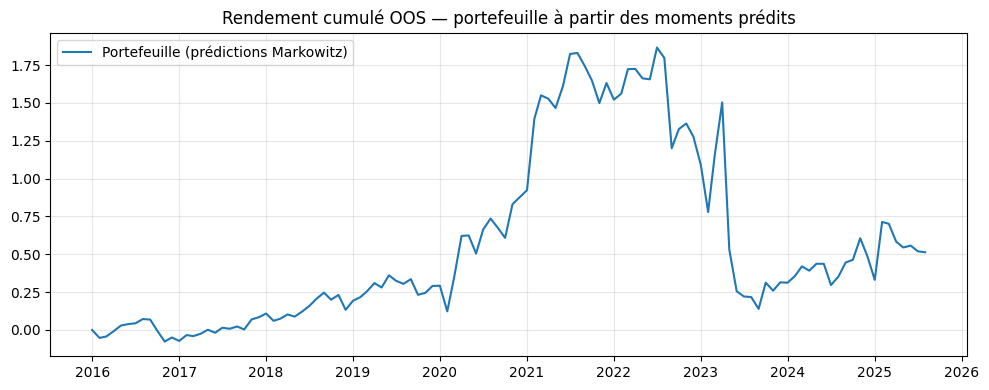

In [ ]:
# Tu as déjà :
# - mu_pred, std_pred, cov_pred = predicted_moments_from_regimes(...)
# - indus_OOS : rendements réalisés OOS (proportions), mêmes colonnes que mean_ind_IS

# Option : fallback si certaines dates n'ont pas de cov (ex: moyenne des Σ_IS)
# Ici on prend la moyenne simple des covariances IS comme secours :
cov_fallback = None
# p.ex. cov_fallback = sum(cov_ind_IS.values()) / len(cov_ind_IS)

# 1) poids Markowitz prévus (tangence par défaut)
W_oos = weights_from_predicted_moments(
    mu_pred = mu_ind_pred,
    cov_pred = cov_ind_pred,          # peut être None si tu veux utiliser uniquement cov_fallback
    method = "tangency",
    rf = 0.0,
    cov_fallback = cov_fallback
)

# 2) rendements du portefeuille (pas de look-ahead)
r_oos = portfolio_returns_from_weights(W_oos, indus_OOS, shift_horizon=1)

# 3) (option) stats et graphe
ann = 12
mean_oos, vol_oos = r_oos.mean(), r_oos.std(ddof=1)
sharpe = (mean_oos*ann) / (vol_oos*np.sqrt(ann)) if vol_oos>0 else np.nan
print(f"Ann. mean={mean_oos*ann:.4f}  Ann. vol={vol_oos*np.sqrt(ann):.4f}  Ann. Sharpe={sharpe:.2f}")

plt.figure(figsize=(10,4))
plt.plot((1+r_oos).cumprod()-1, label="Portefeuille (prédictions Markowitz)")
plt.title("Rendement cumulé OOS — portefeuille à partir des moments prédits")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


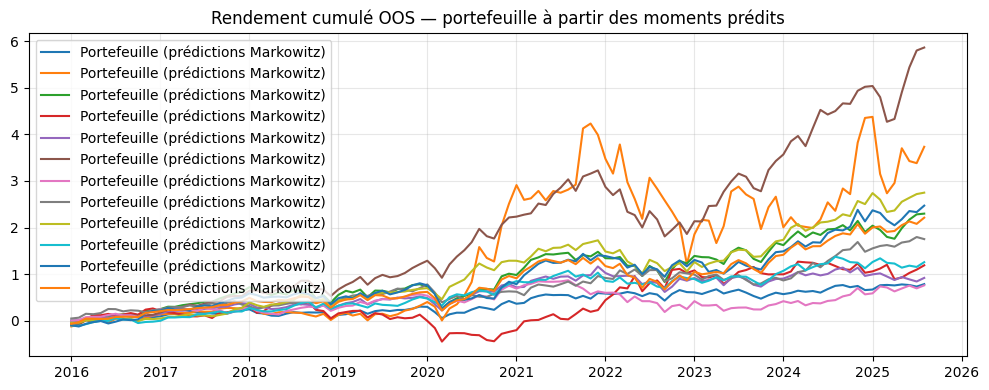

In [ ]:
plt.figure(figsize=(10,4))
plt.plot((1+indus_OOS).cumprod()-1, label="Portefeuille (prédictions Markowitz)")
plt.title("Rendement cumulé OOS — portefeuille à partir des moments prédits")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

Ann. mean=-0.0205  Ann. vol=0.0593  Ann. Sharpe=-0.34


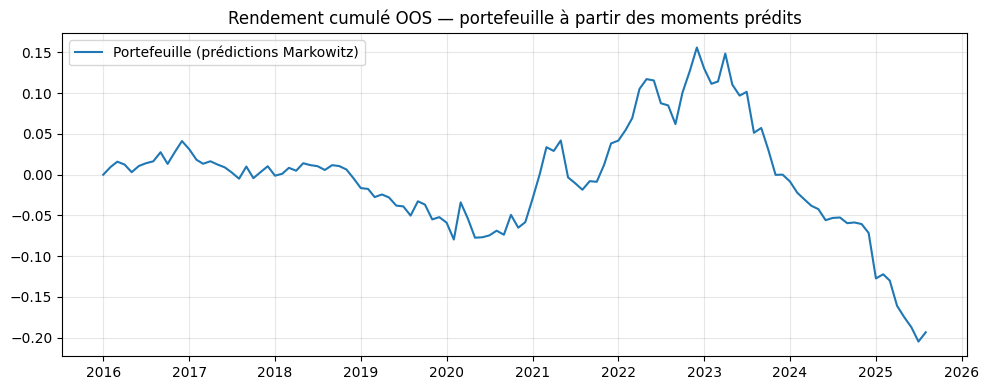

In [ ]:

# Tu as déjà :
# - mu_pred, std_pred, cov_pred = predicted_moments_from_regimes(...)
# - indus_OOS : rendements réalisés OOS (proportions), mêmes colonnes que mean_ind_IS

# Option : fallback si certaines dates n'ont pas de cov (ex: moyenne des Σ_IS)
# Ici on prend la moyenne simple des covariances IS comme secours :
cov_fallback = None
# p.ex. cov_fallback = sum(cov_ind_IS.values()) / len(cov_ind_IS)

# 1) poids Markowitz prévus (tangence par défaut)
W_oos = weights_from_predicted_moments(
    mu_pred = mu_factors_pred,
    cov_pred = cov_factors_pred,          # peut être None si tu veux utiliser uniquement cov_fallback
    method = "tangency",
    rf = 0.0,
    cov_fallback = cov_fallback
)

# 2) rendements du portefeuille (pas de look-ahead)
r_oos = portfolio_returns_from_weights(W_oos, factors_OOS, shift_horizon=1)

# 3) (option) stats et graphe
ann = 12
mean_oos, vol_oos = r_oos.mean(), r_oos.std(ddof=1)
sharpe = (mean_oos*ann) / (vol_oos*np.sqrt(ann)) if vol_oos>0 else np.nan
print(f"Ann. mean={mean_oos*ann:.4f}  Ann. vol={vol_oos*np.sqrt(ann):.4f}  Ann. Sharpe={sharpe:.2f}")

plt.figure(figsize=(10,4))
plt.plot((1+r_oos).cumprod()-1, label="Portefeuille (prédictions Markowitz)")
plt.title("Rendement cumulé OOS — portefeuille à partir des moments prédits")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()
